# Age of the buildings in Paris


Author : Pierre-Olivier Simonard for Quansight

### Introduction

This notebook was inspired by [this Reddit/dataisbeautiful post](https://www.reddit.com/r/dataisbeautiful/comments/ns7mbx/age_of_the_buildings_in_paris_improved_version_oc/) by [Brice Person](https://twitter.com/bjperson). 

By using topological open data and R scripts, he created this image representing the age of buildings in Paris: 

<a href="https://i.redd.it/nvc5ndrwm9371.png" target="_blank"><img src='https://i.redd.it/nvc5ndrwm9371.png' width="400"/></a>


In this notebook, we'll see how to reproduce this image using Python and popular packages : 
- Pandas to work on the data
- Matplotlib to generate the image

In [1]:
import geopandas as gpd

import pandas as pd
#import cartopy
#import cartopy.feature as cf

from cartopy import crs as ccrs

import os
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt


### Download the dataset

The source of the data is [IGN (_Institut Géographique National_), French public administration of geographical information](https://geoservices.ign.fr/documentation/diffusion/telechargement-donnees-libres.html#bd-topo)
 
[Click here to download the dataset](https://geoservices.ign.fr/download/files/158250/056ccf95b9621fd4d29c88b5a12abd0e/0/233/0/1) and unzip it under a directory nammed `data`

----

### Step 1 : Extract the data for Paris only

The downloaded data represent the whole urban area of Paris. Thus, the file is quite big to load while we only need the center of Paris.  
Plus, the data are in the [Lambert Azimuthal Equal Area projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection), which is very convenient in the topography industry, but less convenient for our usage than the [`WGS84` coordinates system](https://epsg.io/4326) (the one we all know as "GPS", also known as `EPSG:4326`)


By exploring [OpenStreetMap](https://www.openstreetmap.org/#map=12/48.8596/2.3452), the WGS84/GPS coordinates of the area we want to keep are roughly :

- south west point : Lat 48.81, Lon 2.23
- north east point : Lat 48.90, Lon 2.44


By [converting](https://epsg.io/transform#s_srs=4326&t_srs=2154&x=2.4400000&y=48.9000000) these coordinates to Lambert Projection, we get : 

- south west point : x=643452.59, y=6856934.42
- north east point : x=658945.27, y=6866811.83

Now, we'll load the data as a geopandas dataframe, keep only the data in the area of interest, and then convert its data into WGS84 for convenience.

In [1]:
#!pip install geopandas
import geopandas as gpd
import pandas as pd
from cartopy import crs as ccrs

#
#from datetime import datetime
#import numpy as np
#import matplotlib.pyplot as plt

In [2]:
xmin = 643452.59
ymin = 6856934.42

xmax = 658945.27
ymax = 6866811.83

In [3]:
# Path to the shapefile of the buildings in Paris' urban area 
shapefile = 'data/BDTOPO_3-0_TOUSTHEMES_SHP_LAMB93_D075_2021-03-15/BDTOPO/1_DONNEES_LIVRAISON_2021-03-00272/BDT_3-0_SHP_LAMB93_D075-ED2021-03-15/BATI/BATIMENT.shp'

# The shapefile contains data in the Lambert Azimuthal projection
proj = ccrs.LambertAzimuthalEqualArea()

# We load the data into a Geopandas Dataframe
area = gpd.read_file(shapefile, crs=proj)

# Now, we restrict the data into the area we're interested in.
# note that the coordinates ranges are lon_min:lon_max, lat_min:lat_max
# as in a xy coordinates system.
paris = area.cx[xmin:xmax , ymin:ymax ]

# We convert the coordinates into WGS84 (i.e. GPS, a.k.a EPSG:4326)
paris = paris.to_crs('EPSG:4326')

This step can take a while.  
If we want to store the extracted data in a shapefile for a later usage, without having to filter again, we do : 

In [5]:
import os
os.makedirs("extracts/PARIS/", exist_ok=True)
paris.to_file("extracts/PARIS/PARIS.shp")

And to load the extracted data, we'll simply do :

In [6]:
shapefile = 'extracts/PARIS/PARIS.shp'
paris = gpd.read_file(shapefile)

In [7]:
len(paris)

214925

### Load the data for Paris

,ID,NATURE,USAGE1,USAGE2,LEGER,ETAT,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,...,MAT_MURS,MAT_TOITS,HAUTEUR,Z_MIN_SOL,Z_MIN_TOIT,Z_MAX_TOIT,Z_MAX_SOL,ORIGIN_BAT,APP_FF,geometry
0,BATIMENT0000000334291707,Indifférenciée,Indifférencié,None,Non,En service,2014-05-20 01:31:39,2019-02-05 17:15:15,None,None,...,None,None,3.1,45.7,48.8,NaN,NaN,Cadastre,None,"POLYGON Z ((2.42392 48.84277 48.80000, 2.42420..."


In [67]:
len(paris)

216510

In [57]:
#paris3035 = paris.to_crs(epsg=3035)
paris3035 = paris.to_crs('EPSG:3035')

CRSError: Invalid projection: EPSG:9820: (Internal Proj Error: proj_create: crs not found)

In [58]:
paris3035.bounds.min(), paris3035.bounds.max()

(minx    3.751342e+06
 miny    2.883630e+06
 maxx    3.751355e+06
 maxy    2.883670e+06
 dtype: float64,
 minx    3.767658e+06
 miny    2.895223e+06
 maxx    3.767682e+06
 maxy    2.895283e+06
 dtype: float64)

### Compute the age of the buildings

The column "DATE_APP" (_date d'apparition_) tells us when then building "appeared". Let's have a look at this column's data :

In [18]:
paris.loc[ paris['DATE_APP'].notnull(), 'DATE_APP' ].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: DATE_APP, dtype: object

In [4]:
len(paris[ paris['DATE_APP'].notnull() ])

121238

In [5]:
paris.loc[ paris['DATE_APP'].notnull(), 'DATE_APP' ].head()

24    1968-01-01
27    1830-01-01
38    1890-01-01
39    1900-01-01
40    1940-01-01
Name: DATE_APP, dtype: object

We can get the age of each building, for which `DATE_APP` is not None, by using the 4 first characters of each string.

In [6]:
def build_age(x):
    
    if x is None:
        return None
    
    return datetime.now().year - int(x[:4])

paris['AGE'] = paris.loc[ :, 'DATE_APP'].apply(build_age)

Now let's plot the distribution of the age of the buildings

<AxesSubplot:>

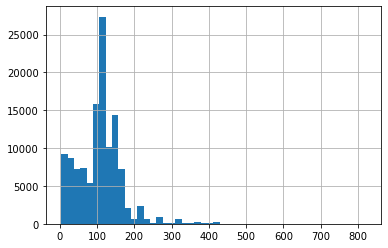

In [7]:
paris['AGE'].hist(bins=48)

<AxesSubplot:>

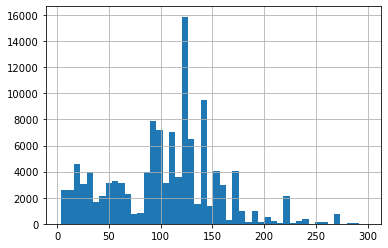

In [8]:
# restrict on builidngs less than 300 years old
paris.loc[  paris['AGE'] < 300 , 'AGE' ].hist(bins=48) 

### Prepare the data for the plot

We need to "bin" the data into discrete intervales based on the age, so the resulting image will have evenly distributed colors.

As `geopandas` relies on `pandas`, we can use the [qcut function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

Let's assume we have a color scale made of 16 colors, we'll want 16 bins :

In [9]:
bins_data = pd.qcut(paris['AGE'], q=16, duplicates='drop', retbins=True)
print(bins_data[0].value_counts())

bins = bins_data[1]
bins

(111.0, 121.0]    18496
(139.0, 141.0]     8887
(102.0, 111.0]     8700
(141.0, 161.0]     8627
(89.0, 95.0]       7907
(3.999, 19.0]      7852
(19.0, 31.0]       7713
(31.0, 51.0]       7679
(129.0, 139.0]     7535
(51.0, 66.0]       7348
(95.0, 102.0]      7347
(181.0, 821.0]     7342
(66.0, 89.0]       7300
(161.0, 181.0]     5409
(121.0, 129.0]     3096
Name: AGE, dtype: int64


array([  4.,  19.,  31.,  51.,  66.,  89.,  95., 102., 111., 121., 129.,
       139., 141., 161., 181., 821.])

In [11]:
# code to generate the image with the same color scale as the original work.

color_scale = [
(23,     (160,   0,  22)    ),
(40,     (186,  34,  30)    ),
(57,     (212,  67,  39)    ),
(77,     (239, 101,  47)    ),
(93,     (255, 135,  62)    ),
(103,    (255, 179,  94)    ),
(115,    (255, 203, 129)    ),
(128,    (255, 238, 165)    ),
(145,    (226, 246, 184)    ),
(164,    (167, 223, 185)    ),
(197,    (109, 202, 187)    ),
(241,    ( 53, 180, 188)    ),
(296,    ( 37, 146, 178)    ),
(361,    ( 36, 110, 164)    ),
(563,    ( 32,  76, 150)    ),
(821,    ( 29,  43, 137)    ) ]


def color_for_age(age):
    if np.isnan(age):
        return '#%02x%02x%02x' % (39, 39, 39)
    
    for (a_limit, (r,g,b)) in color_scale[::-1]:
        if age >= a_limit:
            return '#%02x%02x%02x' % (r, g, b)

In [10]:
# based on : https://bsouthga.dev/posts/color-gradients-with-python


def hex_to_RGB(hex):
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_scale(from_hex, to_hex, n=10):
    
    from_rgb = hex_to_RGB(from_hex)
    to_rgb = hex_to_RGB(to_hex)
    
    result = [from_hex]

    for i in range(1, n):
        new_color = [
            int(from_rgb[j] + (float(i)/(n-1))*(to_rgb[j]-from_rgb[j]))
            for j in range(3)
        ]

        result.append( RGB_to_hex(new_color))

    return result

In [11]:
# Primary colors, according to the palette V1 :
violet = "#452392"
plum = "#A43A8F"
green = "#99C941"

In [12]:
from IPython.core.display import HTML, display

for k in color_scale(violet,plum) + color_scale(plum,green)[1:]:
        display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))

In [28]:
for k in color_scale("#98C841","#FFFFFF"):
        display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))

In [29]:
qs_colors = [ "#613EA3","#673EA1","#6D3D9F","#733D9E","#793D9C","#7F3C9A","#863C98","#8C3B96","#923B94","#983B93","#9E3A91","#A43A8F",    
                "#A34788","#A25481","#A1617A","#A06E73","#9F7B6C","#9E8864","#9D955D","#9CA256","#9BAF4F","#9ABC48","#99C941",][::-1]
for k in qs_colors:
    display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))

In [17]:
# color scale used for the V6
colors_violet = color_scale(violet,plum, 32)[:24]

# Cut in bins
bins = pd.qcut(paris['AGE'], q=len(colors_violet)+1, duplicates='drop', retbins=True)

color_scale_violet = list(zip(bins[1], colors_violet))

#color_scale_purple = color_scale(green,plum) + color_scale(plum,"#D8C9FB")[1:] #   #D8C9FB = "very light shade of violet"
#color_scale_purple = list(zip(bins[1], color_scale_purple))

In [18]:
for (_, k) in color_scale_violet:
    display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))

In [26]:
for k in ['#D8D8D8', '#272727', '#CECECE', '#959DA5', '#'+'5'*6]:
    display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))

In [27]:
def color_for_age(age, color_scale, none_color):
    if np.isnan(age):
        return none_color
    
    for (a_limit, rgb) in color_scale[::-1]:
        if age >= a_limit:
            return rgb 

In [ ]:
dark_mode = True

def generate_map(gdf, filename, color_scale, bg_color='k', none_color='#555555' ):


    ax = plt.figure(figsize = (  65, 45 ) )
    plt.axis('off')
    ax.set_facecolor(bg_color)

    

    for (raw_shape, age) in gdf.loc[:,['geometry', 'AGE']].values:

        x = raw_shape.exterior.coords.xy[0]
        y = raw_shape.exterior.coords.xy[1]
        plt.fill(x, y, c=color_for_age(age, color_scale, none_color))

        for interior in raw_shape.interiors:
            x = [k[0] for k in interior.coords[:]]
            y = [k[1] for k in interior.coords[:]]
            plt.fill(x, y, c=bg_color)


    plt.savefig(filename,  bbox_inches='tight', facecolor=bg_color, edgecolor='none')
    return
    
    
generate_map(paris, 'paris_v6.png', color_scale=color_scale_violet)
print("done")